### Read in unemployment data csv, clean the 'Geography' column to be standardized, and output as geojson

In [2]:
import os
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
notebook_dir = os.getcwd() 
secondary_data_dir = os.path.join(notebook_dir, "..", "data", "secondary_data")

In [4]:
unemployment_csv = os.path.join(secondary_data_dir, "unemployment_data", "unemployment.csv")
map_path = os.path.join(secondary_data_dir, "unemployment_data", "tl_2024_25_tract", "tl_2024_25_tract.shp")
output_geojson = os.path.join(secondary_data_dir, "unemployment_data", "unemployment_boundary.geojson")

In [5]:
STATE_FIPS = "25"  #Massachusetts
COUNTY_FIPS = "009"  # Essex County

# COLUMN NAMES
COL_GEOG = "Geography"
COL_EST = "Unemployment rate—Population 16 years and over—Estimate"
COL_MOE = "MoE"

In [7]:
# load and clean tracts like in poverty workflow
def load_and_clean_tracts_map(map_path, state_fips="25", county_fips="009"):
    gdf = gpd.read_file(map_path)
    # Filter by FIPS codes if present
    if "STATEFP" in gdf.columns and "COUNTYFP" in gdf.columns:
        gdf = gdf[(gdf["STATEFP"] == state_fips) & (gdf["COUNTYFP"] == county_fips)]
    # Normalize NAME to "Census Tract ####"
    gdf["NAME"] = gdf["NAME"].astype(str).str.split(".").str[0]
    gdf["NAME"] = "Census Tract " + gdf["NAME"]
    return gdf

In [8]:
# 1) Read CSV and normalize the Geography text
df = pd.read_csv(unemployment_csv, dtype=str, keep_default_na=False)

In [9]:
df.head()

,Geography,Unemployment rate—Population 16 years and over—Estimate,MoE
0,Census Tract 2501; Essex County; Massachusetts,9.6%,± 5.5%
1,Census Tract 2502; Essex County; Massachusetts,11.3%,± 5%
2,Census Tract 2503; Essex County; Massachusetts,10.4%,± 5.2%
3,Census Tract 2504; Essex County; Massachusetts,12%,± 10.3%
4,Census Tract 2505; Essex County; Massachusetts,8.3%,± 4.1%


In [10]:
def normalize_geography(text: str) -> str:
    # "Census Tract 2501; Essex County; Massachusetts"
    # Convert to "Census Tract 2501, Essex County, Massachusetts"
    return re.sub(r"\s*;\s*", ", ", text.strip())

df[COL_GEOG] = df[COL_GEOG].apply(normalize_geography)

In [11]:
# Extract "Census Tract ####" for joining to tract NAME
df["tract"] = df[COL_GEOG].str.extract(r"(Census Tract \d+)")

In [12]:
df.head()

,Geography,Unemployment rate—Population 16 years and over—Estimate,MoE,tract
0,"Census Tract 2501, Essex County, Massachusetts",9.6%,± 5.5%,Census Tract 2501
1,"Census Tract 2502, Essex County, Massachusetts",11.3%,± 5%,Census Tract 2502
2,"Census Tract 2503, Essex County, Massachusetts",10.4%,± 5.2%,Census Tract 2503
3,"Census Tract 2504, Essex County, Massachusetts",12%,± 10.3%,Census Tract 2504
4,"Census Tract 2505, Essex County, Massachusetts",8.3%,± 4.1%,Census Tract 2505


In [13]:
# 2) Clean numeric fields
# Estimate like "65.6%" -> 65.6 as float
df["Estimate"] = (
    df[COL_EST]
    .str.replace("%", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)
print(df["Estimate"])

0      9.6
1     11.3
2     10.4
3     12.0
4      8.3
5     10.9
6      7.4
7      9.2
8     11.2
9     10.2
10     5.2
11     5.0
12    12.4
13    12.8
14     4.7
15    11.4
16     8.2
17     2.3
Name: Estimate, dtype: float64


In [14]:
print(df["MoE"])

0      ± 5.5%
1        ± 5%
2      ± 5.2%
3     ± 10.3%
4      ± 4.1%
5      ± 4.8%
6      ± 4.3%
7      ± 5.3%
8      ± 9.9%
9      ± 8.5%
10     ± 5.7%
11     ± 6.7%
12     ± 6.7%
13     ± 6.8%
14     ± 3.5%
15     ± 9.1%
16     ± 4.7%
17     ± 2.1%
Name: MoE, dtype: object


In [15]:
# MoE like "± 7.6%" or "± 7.6%" with narrow spaces
df["MoE"] = (
    df[COL_MOE]
    .str.replace("±", "", regex=False)
    .str.replace("%", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
    .astype(float)
)
print(df["MoE"])

0      5.5
1      5.0
2      5.2
3     10.3
4      4.1
5      4.8
6      4.3
7      5.3
8      9.9
9      8.5
10     5.7
11     6.7
12     6.7
13     6.8
14     3.5
15     9.1
16     4.7
17     2.1
Name: MoE, dtype: float64


In [16]:
employment_wide = df[["tract", "Estimate", "MoE"]].copy()

# -------------------------------------------------------------------
# 3) Load tract shapes and merge
# -------------------------------------------------------------------
tracts_gdf = load_and_clean_tracts_map(map_path, STATE_FIPS, COUNTY_FIPS)
merged_gdf = tracts_gdf.merge(employment_wide, left_on="NAME", right_on="tract", how="left")

In [17]:
print(merged_gdf)

    STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ  \
0        25      009  217402  25009217402  1400000US25009217402   
1        25      009  202104  25009202104  1400000US25009202104   
2        25      009  202103  25009202103  1400000US25009202103   
3        25      009  217602  25009217602  1400000US25009217602   
4        25      009  217102  25009217102  1400000US25009217102   
..      ...      ...     ...          ...                   ...   
169      25      009  208302  25009208302  1400000US25009208302   
170      25      009  212101  25009212101  1400000US25009212101   
171      25      009  208401  25009208401  1400000US25009208401   
172      25      009  208402  25009208402  1400000US25009208402   
173      25      009  212102  25009212102  1400000US25009212102   

                  NAME              NAMELSAD  MTFCC FUNCSTAT     ALAND  \
0    Census Tract 2174  Census Tract 2174.02  G5020        S    767215   
1    Census Tract 2021  Census Tract 2021.04  G

In [18]:
# Drop tracts with no match, optional
merged_gdf = merged_gdf.dropna(subset=["Estimate"])

# Ensure GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry="geometry", crs=tracts_gdf.crs)

In [19]:
# -------------------------------------------------------------------
# 4) Save GeoJSON
# -------------------------------------------------------------------
merged_gdf.to_file(output_geojson, driver="GeoJSON")
print(f"[DONE] Saved employment GeoJSON to: {output_geojson}")

[DONE] Saved employment GeoJSON to: c:\Users\Indel\Documents\gatewayinitiative-lawrencepd\scripts\..\data\secondary_data\unemployment_data\unemployment_boundary.geojson


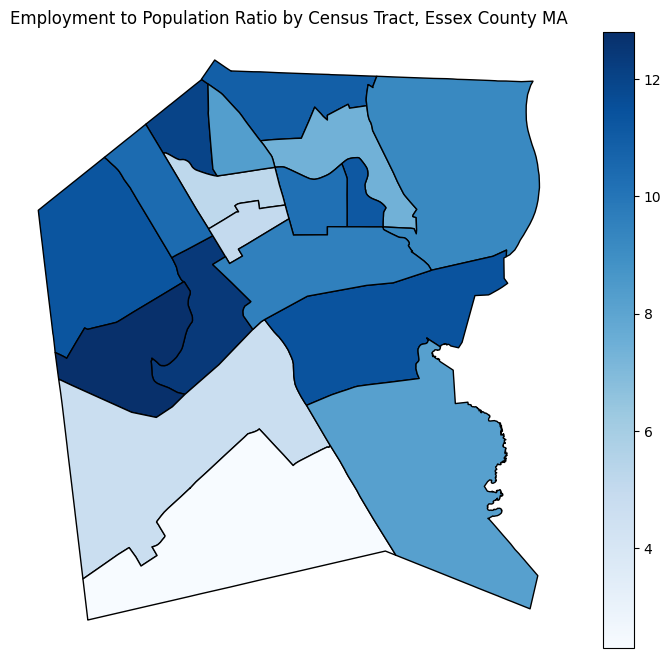

In [20]:
# -------------------------------------------------------------------
# 5) Plot
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
merged_gdf.plot(
    column="Estimate",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    ax=ax
)
ax.set_title("Employment to Population Ratio by Census Tract, Essex County MA")
plt.axis("off")
plt.show()
